In [1]:
# Tutorial of UQPINNs on a simple nonlinear ordinary equation:

# u_xx - u^2 u_x = f(x) 
# with f(x) = -\pi^2 sin(\pi x) - \pi cos(\pi x)sin(\pi x)^2

# The solution of the above equation is u(x) = sin(\pi x)

# More examples can be found in paper:  
#Yibo, Yang and Paris Perdikaris. "Adversarial Uncertainty Quantification in Physics-Informed Neural Networks."  on Journal of Computational Physics


In [2]:
# Define the model class
import tensorflow as tf
import numpy as np
import timeit

# Model class takes the intput:
# X_f: collocation points in [-1, 1], X_u: positions on the boundary (in this case -1 and 1), 
# Y_u: data on the boundary (in this case, boundary conditions), layers_P: network structure of generator,
# layers_Q: network structure of encoder, layers_T: network structure of discriminator,
# lam: entropic regularization coefficient, beta: physics-informed regularization

class ODE_UQPINN:
    # Initialize the class
    def __init__(self, X_f, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.0, beta = 1.0): # X_f: collocation points, X_u: input data X, Y_u: output data Y,
        # layers_P: decoder network structure, layers_Q: encoder network structure, layers_T: discriminator network structure,
        # lam: entropic regularization parameter, beta: physics-informed regularization parameter
                
        # Normalize data
        self.Xmean, self.Xstd = X_f.mean(0), X_f.std(0)
        self.Ymean, self.Ystd = Y_u.mean(0), Y_u.std(0)
        X_f = (X_f - self.Xmean) / self.Xstd
        X_u = (X_u - self.Xmean) / self.Xstd
        # Jacobian with respect to the normalization
        self.Jacobian = 1 / self.Xstd
        
        # Normalized and collocation points and training input, output data
        self.X_f = X_f
        self.X_u = X_u
        self.Y_u = Y_u
        
        # Neural network structures
        self.layers_P = layers_P
        self.layers_Q = layers_Q
        self.layers_T = layers_T
        
        # Input, output and latent variable dimensions
        self.X_dim = X_u.shape[1]
        self.Y_dim = Y_u.shape[1]
        self.Z_dim = layers_Q[-1]
        
        # Regularization parameters
        self.lam = lam
        self.beta = beta
        
        # Ratio of training for generator and discriminator in each iteration: k1 for discriminator, k2 for generator
        self.k1 = 1
        self.k2 = 5

        # Initialize network weights and biases        
        self.weights_P, self.biases_P = self.initialize_NN(layers_P)
        self.weights_Q, self.biases_Q = self.initialize_NN(layers_Q)
        self.weights_T, self.biases_T = self.initialize_NN(layers_T)
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        
        # Define placeholders and computational graph
        self.X_u_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.X_f_tf = tf.placeholder(tf.float32, shape=(None, self.X_dim))
        self.Y_u_tf = tf.placeholder(tf.float32, shape=(None, self.Y_dim))
        self.Z_u_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))
        self.Z_f_tf = tf.placeholder(tf.float32, shape=(None, self.Z_dim))

        # Predict output
        self.Y_u_pred = self.net_P(self.X_u_tf, self.Z_u_tf)
        # Predict the residual at collocation points
        self.Y_f_pred = self.get_r(self.X_f_tf, self.Z_f_tf)

        # Generator loss (to be minimized)
        self.G_loss, self.KL_loss, self.recon_loss, self.PDE_loss  = self.compute_generator_loss(self.X_u_tf, self.Y_u_tf, self.Y_u_pred,
                                                                        self.X_f_tf, self.Y_f_pred, self.Z_u_tf, self.Z_f_tf)
                                                
        # Discriminator loss (to be minimized)
        self.T_loss  = self.compute_discriminator_loss(self.X_u_tf, self.Y_u_tf, self.Z_u_tf)
        
        # Generate samples of y given x by sampling from latent space
        self.sample = self.sample_generator(self.X_u_tf, self.Z_u_tf)

        # Define optimizer        
        self.optimizer_KL = tf.train.AdamOptimizer(1e-4)
        self.optimizer_T = tf.train.AdamOptimizer(1e-4)
        
        # Define train Ops
        self.train_op_KL = self.optimizer_KL.minimize(self.G_loss, 
                                                      var_list = [self.weights_P, self.biases_P,
                                                                  self.weights_Q, self.biases_Q])
                                                                    
        self.train_op_T = self.optimizer_T.minimize(self.T_loss,
                                                    var_list = [self.weights_T, self.biases_T])

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
           
           
    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    # Forcing term (right hand of the ODE)
    def f(self, X_normalized): #
        X = self.Xstd * X_normalized + self.Xmean
        return - np.pi ** 2 * tf.sin(np.pi*X) - np.pi * tf.cos(np.pi * X) * tf.sin(np.pi * X) ** 2
    
    # Decoder: p(y|x,z)
    def net_P(self, X, Z):
        Y = self.forward_pass(tf.concat([X, Z], 1),
                              self.layers_P,
                              self.weights_P,
                              self.biases_P)
        return Y
    
    # Encoder: q(z|x,y)
    def net_Q(self, X, Y):
        Z = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_Q,
                              self.weights_Q,
                              self.biases_Q)
        return Z
    
    # Discriminator
    def net_T(self, X, Y):
        T = self.forward_pass(tf.concat([X, Y], 1),
                              self.layers_T,
                              self.weights_T,
                              self.biases_T)        
        return T
    
    # Physics-Informed neural network prediction
    def get_u(self, X, Z):
        z_prior = Z       
        u = self.net_P(X, z_prior)
        return u

    # Physics-Informed residual on the collocation points
    def get_r(self, X, Z):
        z_prior = Z    
        u = self.net_P(X, z_prior)
        u_x = tf.gradients(u, X)[0]
        u_xx = tf.gradients(u_x, X)[0]
        f = self.f(X)
        r = (self.Jacobian ** 2) * u_xx - (self.Jacobian) * (u ** 2) *u_x - f
        return r    
    
    # Compute the generator loss
    def compute_generator_loss(self, X_u, Y_u, Y_u_pred, X_f, Y_f_pred, Z_u, Z_f):  
        # Prior: z_u for input data, z_f for collocation points
        z_u_prior = Z_u
        z_f_prior = Z_f
        # Encoder: q(z|x,y)
        z_u_encoder = self.net_Q(X_u, Y_u_pred)
        z_f_encoder = self.net_Q(X_f, Y_f_pred)
        # Discriminator loss
        Y_pred = self.net_P(X_u, Z_u)
        T_pred = self.net_T(X_u, Y_pred)
        
        # KL-divergence between the data distribution and the model distribution
        KL = tf.reduce_mean(T_pred)

        # Entropic regularization
        log_q = - tf.reduce_mean(tf.square(z_u_prior-z_u_encoder))
        
        # Physics-informed loss
        loss_f = tf.reduce_mean(tf.square(Y_f_pred))

        # Generator loss
        loss = KL + (1.0-self.lam)*log_q + self.beta * loss_f
        
        return loss, KL, (1.0-self.lam)*log_q, self.beta * loss_f
    
    # Compute the discriminator loss
    def compute_discriminator_loss(self, X, Y, Z): 
        # Prior: p(z)
        z_prior = Z
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)                
        
        # Discriminator loss
        T_real = self.net_T(X, Y)
        T_fake = self.net_T(X, Y_pred)
        
        T_real = tf.sigmoid(T_real)
        T_fake = tf.sigmoid(T_fake)
        
        T_loss = -tf.reduce_mean(tf.log(1.0 - T_real + 1e-8) + \
                                 tf.log(T_fake + 1e-8)) 
        
        return T_loss
           
    
    # Fetches a mini-batch of data
    def fetch_minibatch(self,X, Y, N_batch):
        N = X.shape[0]
        idx = np.random.choice(N, N_batch, replace=False)
        X_batch = X[idx,:]
        Y_batch = Y[idx,:]
        return X_batch, Y_batch
    
    
    # Trains the model
    def train(self, nIter = 20000, N_u = 2, N_f = 100): 

        start_time = timeit.default_timer()
        for it in range(nIter):     

            # Sampling from the latent space for data and collocation points
            Z_u = np.random.randn(N_u, self.Z_dim)
            Z_f = np.random.randn(N_f, self.Z_dim)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.X_u_tf: self.X_u, self.Y_u_tf: self.Y_u, self.X_f_tf: self.X_f,
                     self.Z_u_tf: Z_u, self.Z_f_tf: Z_f}  
            
            # Run the Tensorflow session to minimize the loss
            for i in range(self.k1):
                self.sess.run(self.train_op_T, tf_dict)
            for j in range(self.k2):
                self.sess.run(self.train_op_KL, tf_dict)
        
            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_KL_value, reconv, loss_PDE = self.sess.run([self.KL_loss, self.recon_loss, self.PDE_loss], tf_dict)
                loss_T_value = self.sess.run(self.T_loss, tf_dict)
                print('It: %d, KL_loss: %.2e, Recon_loss: %.2e, PDE_loss: %.2e, T_loss: %.2e, Time: %.2f' % 
                      (it, loss_KL_value, reconv, loss_PDE, loss_T_value, elapsed))
                start_time = timeit.default_timer()
                
    # Generate samples of y given x by sampling from the latent space z
    def sample_generator(self, X, Z):        
        # Prior:
        z_prior = Z       
        # Decoder: p(y|x,z)
        Y_pred = self.net_P(X, z_prior)      
        return Y_pred

    # Predict y given x
    def generate_sample(self, X_star):
        # Normalize the input data
        X_star = (X_star - self.Xmean) / self.Xstd
        Z = np.random.randn(X_star.shape[0], self.Z_dim)
        tf_dict = {self.X_u_tf: X_star, self.Z_u_tf: Z}       
        Y_star = self.sess.run(self.sample, tf_dict) 
        Y_star = Y_star 
        return Y_star

In [3]:
# Implementation 

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

np.random.seed(1234)

In [5]:
# Number of collocation points
N_f = 100

# Number of testing points
N_ref = 200

# Number of the training data (in this example on the boundary)
N_u = 20

# Define the input, output, latent variable dimension
X_dim = 1
Y_dim = 1
Z_dim = 1

# Reference solution
def f(X):
    return np.sin(np.pi * X)

# Position of the collocation points
X_f = np.linspace(-1.,1.,N_f)[:,None]

# Position of the boundary of the problem
X_ut = np.linspace(-1.,1.,2)[:,None]
X_u = X_ut
for i in range(N_u-1):
    X_u = np.vstack((X_u, X_ut))

# Generate stochastic boundary condition
Y_ut = f(X_ut)
Y_u = Y_ut + 0.05 * np.random.randn(2, Y_dim)
for i in range(N_u-1):
    Y_ut = 0.05 * np.random.randn(2, Y_dim)
    Y_u = np.vstack((Y_u, Y_ut))

# Reference solution on the testing points
X_ref = np.linspace(-1.,1.,N_ref)[:,None]
Y_ref = f(X_ref)

# Load the reference solution of the stochastic ODE generated by Monte Carlo
data = scipy.io.loadmat('./ODE2000.mat')
Exact = np.real(data['U']).T

In [6]:
# Model creation
layers_P = np.array([X_dim+Z_dim,50,50,50,50,Y_dim])
layers_Q = np.array([X_dim+Y_dim,50,50,50,50,Z_dim])
layers_T = np.array([X_dim+Y_dim,50,50,1])

# Define the model
model = ODE_UQPINN(X_f, X_u, Y_u, layers_P, layers_Q, layers_T, lam = 1.5, beta = 1.)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
# Train the model
model.train(nIter = 30000, N_u = 2*N_u, N_f = N_f)

It: 0, KL_loss: -1.85e-04, Recon_loss: 4.30e-01, PDE_loss: 4.98e+01, T_loss: 1.42e+00, Time: 2.93
It: 100, KL_loss: 1.19e-01, Recon_loss: 7.45e-01, PDE_loss: 6.86e+00, T_loss: 1.31e+00, Time: 5.28
It: 200, KL_loss: -4.03e-02, Recon_loss: 3.61e-01, PDE_loss: 4.83e-01, T_loss: 1.40e+00, Time: 5.45
It: 300, KL_loss: 8.76e-02, Recon_loss: 4.32e-01, PDE_loss: 2.57e-01, T_loss: 1.33e+00, Time: 5.10
It: 400, KL_loss: -2.58e-02, Recon_loss: 2.43e-01, PDE_loss: 2.79e-01, T_loss: 1.37e+00, Time: 5.28
It: 500, KL_loss: -5.77e-02, Recon_loss: 8.63e-03, PDE_loss: 1.43e-01, T_loss: 1.43e+00, Time: 5.28
It: 600, KL_loss: 4.26e-02, Recon_loss: 1.87e-03, PDE_loss: 5.83e-02, T_loss: 1.37e+00, Time: 5.49
It: 700, KL_loss: -1.57e-02, Recon_loss: 6.57e-03, PDE_loss: 2.34e-02, T_loss: 1.38e+00, Time: 5.35
It: 800, KL_loss: -1.25e-02, Recon_loss: 1.56e-03, PDE_loss: 2.70e-02, T_loss: 1.40e+00, Time: 5.40
It: 900, KL_loss: 5.23e-04, Recon_loss: 7.68e-04, PDE_loss: 1.27e-02, T_loss: 1.38e+00, Time: 5.20
It: 10

It: 8200, KL_loss: -4.97e-03, Recon_loss: 1.49e-04, PDE_loss: 6.37e-04, T_loss: 1.38e+00, Time: 5.35
It: 8300, KL_loss: 5.24e-03, Recon_loss: 3.88e-05, PDE_loss: 5.84e-04, T_loss: 1.39e+00, Time: 5.46
It: 8400, KL_loss: -7.55e-03, Recon_loss: 7.84e-05, PDE_loss: 6.18e-04, T_loss: 1.39e+00, Time: 5.30
It: 8500, KL_loss: 6.42e-03, Recon_loss: 1.00e-04, PDE_loss: 6.88e-04, T_loss: 1.39e+00, Time: 5.37
It: 8600, KL_loss: -7.48e-03, Recon_loss: 8.83e-05, PDE_loss: 5.06e-04, T_loss: 1.39e+00, Time: 5.31
It: 8700, KL_loss: 7.02e-03, Recon_loss: 1.29e-05, PDE_loss: 5.58e-04, T_loss: 1.39e+00, Time: 5.55
It: 8800, KL_loss: -7.09e-03, Recon_loss: 2.02e-05, PDE_loss: 4.66e-04, T_loss: 1.39e+00, Time: 5.65
It: 8900, KL_loss: 9.16e-03, Recon_loss: 1.08e-03, PDE_loss: 5.51e-04, T_loss: 1.38e+00, Time: 5.39
It: 9000, KL_loss: -7.97e-03, Recon_loss: 1.62e-04, PDE_loss: 3.89e-04, T_loss: 1.39e+00, Time: 5.70
It: 9100, KL_loss: 5.67e-03, Recon_loss: 2.16e-04, PDE_loss: 3.68e-04, T_loss: 1.39e+00, Time: 

It: 16300, KL_loss: 1.21e-02, Recon_loss: 7.16e-04, PDE_loss: 1.65e-04, T_loss: 1.39e+00, Time: 5.48
It: 16400, KL_loss: -2.32e-03, Recon_loss: 5.25e-05, PDE_loss: 1.06e-04, T_loss: 1.39e+00, Time: 5.33
It: 16500, KL_loss: -8.79e-03, Recon_loss: 1.85e-05, PDE_loss: 7.94e-05, T_loss: 1.39e+00, Time: 5.46
It: 16600, KL_loss: -8.54e-03, Recon_loss: 8.83e-06, PDE_loss: 7.09e-05, T_loss: 1.39e+00, Time: 5.20
It: 16700, KL_loss: -8.67e-03, Recon_loss: 7.27e-06, PDE_loss: 6.27e-05, T_loss: 1.39e+00, Time: 5.80
It: 16800, KL_loss: 4.32e-04, Recon_loss: 5.34e-04, PDE_loss: 9.38e-05, T_loss: 1.39e+00, Time: 5.54
It: 16900, KL_loss: 1.36e-03, Recon_loss: 6.93e-06, PDE_loss: 5.47e-05, T_loss: 1.39e+00, Time: 5.48
It: 17000, KL_loss: 6.59e-03, Recon_loss: 2.17e-04, PDE_loss: 4.51e-05, T_loss: 1.39e+00, Time: 5.71
It: 17100, KL_loss: -6.76e-04, Recon_loss: 7.08e-06, PDE_loss: 5.30e-05, T_loss: 1.39e+00, Time: 5.61
It: 17200, KL_loss: 6.73e-03, Recon_loss: 2.08e-05, PDE_loss: 1.38e-04, T_loss: 1.39e+

It: 24400, KL_loss: -1.54e-02, Recon_loss: 1.09e-03, PDE_loss: 1.32e-04, T_loss: 1.39e+00, Time: 5.63
It: 24500, KL_loss: -1.31e-02, Recon_loss: 3.40e-04, PDE_loss: 7.05e-05, T_loss: 1.39e+00, Time: 5.24
It: 24600, KL_loss: 8.57e-03, Recon_loss: 1.54e-05, PDE_loss: 7.74e-05, T_loss: 1.39e+00, Time: 5.60
It: 24700, KL_loss: -1.56e-03, Recon_loss: 1.48e-03, PDE_loss: 9.02e-05, T_loss: 1.39e+00, Time: 5.54
It: 24800, KL_loss: 9.54e-03, Recon_loss: 3.45e-04, PDE_loss: 6.40e-05, T_loss: 1.39e+00, Time: 5.68
It: 24900, KL_loss: -6.88e-03, Recon_loss: 2.14e-05, PDE_loss: 5.09e-05, T_loss: 1.39e+00, Time: 5.75
It: 25000, KL_loss: -3.53e-03, Recon_loss: 1.09e-04, PDE_loss: 3.79e-05, T_loss: 1.39e+00, Time: 5.60
It: 25100, KL_loss: -8.72e-03, Recon_loss: 3.16e-06, PDE_loss: 4.90e-05, T_loss: 1.39e+00, Time: 5.79
It: 25200, KL_loss: 2.46e-03, Recon_loss: 1.68e-05, PDE_loss: 3.92e-05, T_loss: 1.39e+00, Time: 5.70
It: 25300, KL_loss: -1.00e-02, Recon_loss: 8.62e-05, PDE_loss: 4.99e-05, T_loss: 1.39

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


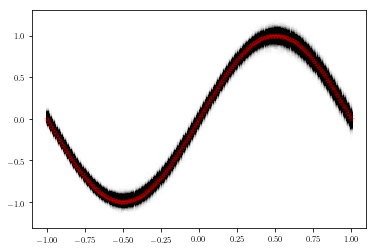

In [8]:
# Prediction

# Make prediciton at randomly chosen points X_ff (black lines are generated samples, red stars are predicted mean)
plt.figure(1)
N_samples = 2000
samples_mean = np.zeros((X_ref.shape[0], N_samples))
for i in range(0, N_samples):
    samples_mean[:,i:i+1] = model.generate_sample(X_ref)
    plt.plot(X_ref, samples_mean[:,i:i+1],'k.', alpha = 0.005)
plt.plot(X_ref, Y_ref, 'r*',alpha = 0.2)
plt.show()

# Compute the mean and the variance of the prediction at randomly selected points in the domain
mu_pred = np.mean(samples_mean, axis = 1)    
Sigma_pred = np.var(samples_mean, axis = 1)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


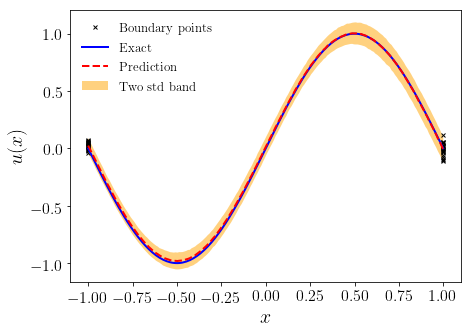

In [9]:
# Plot the prediction with the uncertainty versus the reference solution

ax = plt.figure(2,figsize=(7,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.plot(X_u, Y_u, 'kx', markersize = 4, label = "Boundary points")
lower = mu_pred - 2.0*np.sqrt(Sigma_pred)
upper = mu_pred + 2.0*np.sqrt(Sigma_pred)
plt.fill_between(X_ref.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_ref,Y_ref,'b-', label = "Exact", linewidth=2)
plt.plot(X_ref, mu_pred, 'r--', label = "Prediction", linewidth=2)
plt.xlabel('$x$',fontsize=20)
plt.ylabel('$u(x)$',fontsize=20)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

In [10]:
# Compute the prediction relative error 

mu_pred = mu_pred[:,None]
error_u = np.linalg.norm(Y_ref-mu_pred,2)/np.linalg.norm(Y_ref,2)
print('Error u: %e' % (error_u))  

Error u: 2.029570e-02


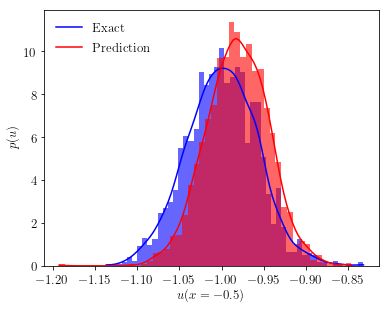

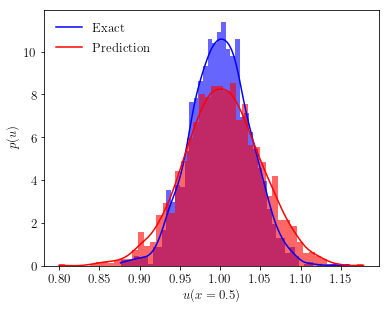

In [11]:
######### Compare the uncertainty at x = -0.5 and x = 0.5 ########

# E1 and E3 represent the samples of reference solution at x = -0.5 and x = 0.5
E1 = Exact[50,:][:, None]
E3 = Exact[150,:][:, None]

# M1 and M3 represent the samples of our generative model at x = -0.5 and x = 0.5
M1 = samples_mean[50,:][:, None]
M3 = samples_mean[150,:][:, None]


######## Probability density kernel estimation ########

# Kernel density estimation of reference solution at x = -0.5
xmin, xmax = E1.min(), E1.max()
X_marginal_1 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_1 = X_marginal_1.flatten()
values_marginal_1 = E1.flatten()
gkde = stats.gaussian_kde(values_marginal_1)
KDE_marginal_1 = gkde.evaluate(positions_marginal_1)

# Kernel density estimation of reference solution at x = 0.5
xmin, xmax = E3.min(), E3.max()
X_marginal_3 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_3 = X_marginal_3.flatten()
values_marginal_3 = E3.flatten()
gkde = stats.gaussian_kde(values_marginal_3)
KDE_marginal_3 = gkde.evaluate(positions_marginal_3)

# Kernel density estimation of generative model solution at x = -0.5
xmin, xmax = M1.min(), M1.max()
X_marginal_4 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_4 = X_marginal_4.flatten()
values_marginal_4 = M1.flatten()
gkde = stats.gaussian_kde(values_marginal_4)
KDE_marginal_4 = gkde.evaluate(positions_marginal_4)

# Kernel density estimation of generative model solution at x = 0.5
xmin, xmax = M3.min(), M3.max()
X_marginal_6 = np.linspace(xmin, xmax, 100)[:,None]
positions_marginal_6 = X_marginal_6.flatten()
values_marginal_6 = M3.flatten()
gkde = stats.gaussian_kde(values_marginal_6)
KDE_marginal_6 = gkde.evaluate(positions_marginal_6)


# Comparion of the probability density of the reference solution and our model solution at x = -0.5
ax = plt.figure(3,figsize=(6,4.7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.hist(Exact[50,:], bins = 50, density=True, alpha = 0.6, color='blue')
plt.hist(samples_mean[50,:], bins = 50, density=True, alpha = 0.6, color='red')
plt.plot(X_marginal_1, KDE_marginal_1, 'b-', label = 'Exact')
plt.plot(X_marginal_4, KDE_marginal_4, 'r-', label = 'Prediction')
plt.xlabel('$u(x = - 0.5)$',fontsize=13)
plt.ylabel('$p(u)$',fontsize=13)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()

# Comparion of the probability density of the reference solution and our model solution at x = 0.5
ax = plt.figure(5,figsize=(6,4.7))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.hist(Exact[150,:], bins = 50, density=True, alpha = 0.6, color='blue')
plt.hist(samples_mean[150,:], bins = 50, density=True, alpha = 0.6, color='red')
plt.plot(X_marginal_3, KDE_marginal_3, 'b-', label = 'Exact')
plt.plot(X_marginal_6, KDE_marginal_6, 'r-', label = 'Prediction')
plt.xlabel('$u(x = 0.5)$',fontsize=13)
plt.ylabel('$p(u)$',fontsize=13)
plt.legend(loc='upper left', frameon=False, prop={'size': 13})
plt.show()